In [6]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
%config Completer.use_jedi = False

In [8]:
torch.__version__

'1.8.1'

In [9]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)
model.eval()


Using cache found in C:\Users\WIN10/.cache\torch\hub\pytorch_vision_v0.9.0


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [10]:
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.LogSoftmax()
        )
        
    def forward(self, x):
        return self.mnet(x)

    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self):        
        for param in self.mnet.parameters():
            param.requires_grad = True        

In [12]:
weights = torch.load("model/weights_best.pth", map_location="cpu")
config = torch.load("model/configs.pth", map_location="cpu")
model = CustomMobilenetV2(2)
model.load_state_dict(weights)
model = model.to(device)

Using cache found in C:\Users\WIN10/.cache\torch\hub\pytorch_vision_v0.9.0


In [14]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import BytesIO
from torch.utils.data import DataLoader, TensorDataset

In [32]:
bs = 9

crop_size = 256

test_transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

test_set = datasets.ImageFolder("Val 2/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs,  shuffle=True)

In [33]:
feature, target = next(iter(testloader))
feature.shape

torch.Size([9, 3, 256, 256])

In [34]:
with torch.no_grad():
    model.eval()
    output = model(feature.to(device))
    preds = output.argmax(1)
preds

D:\Pemrograman\miniconda3\envs\my_env\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([1, 1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')

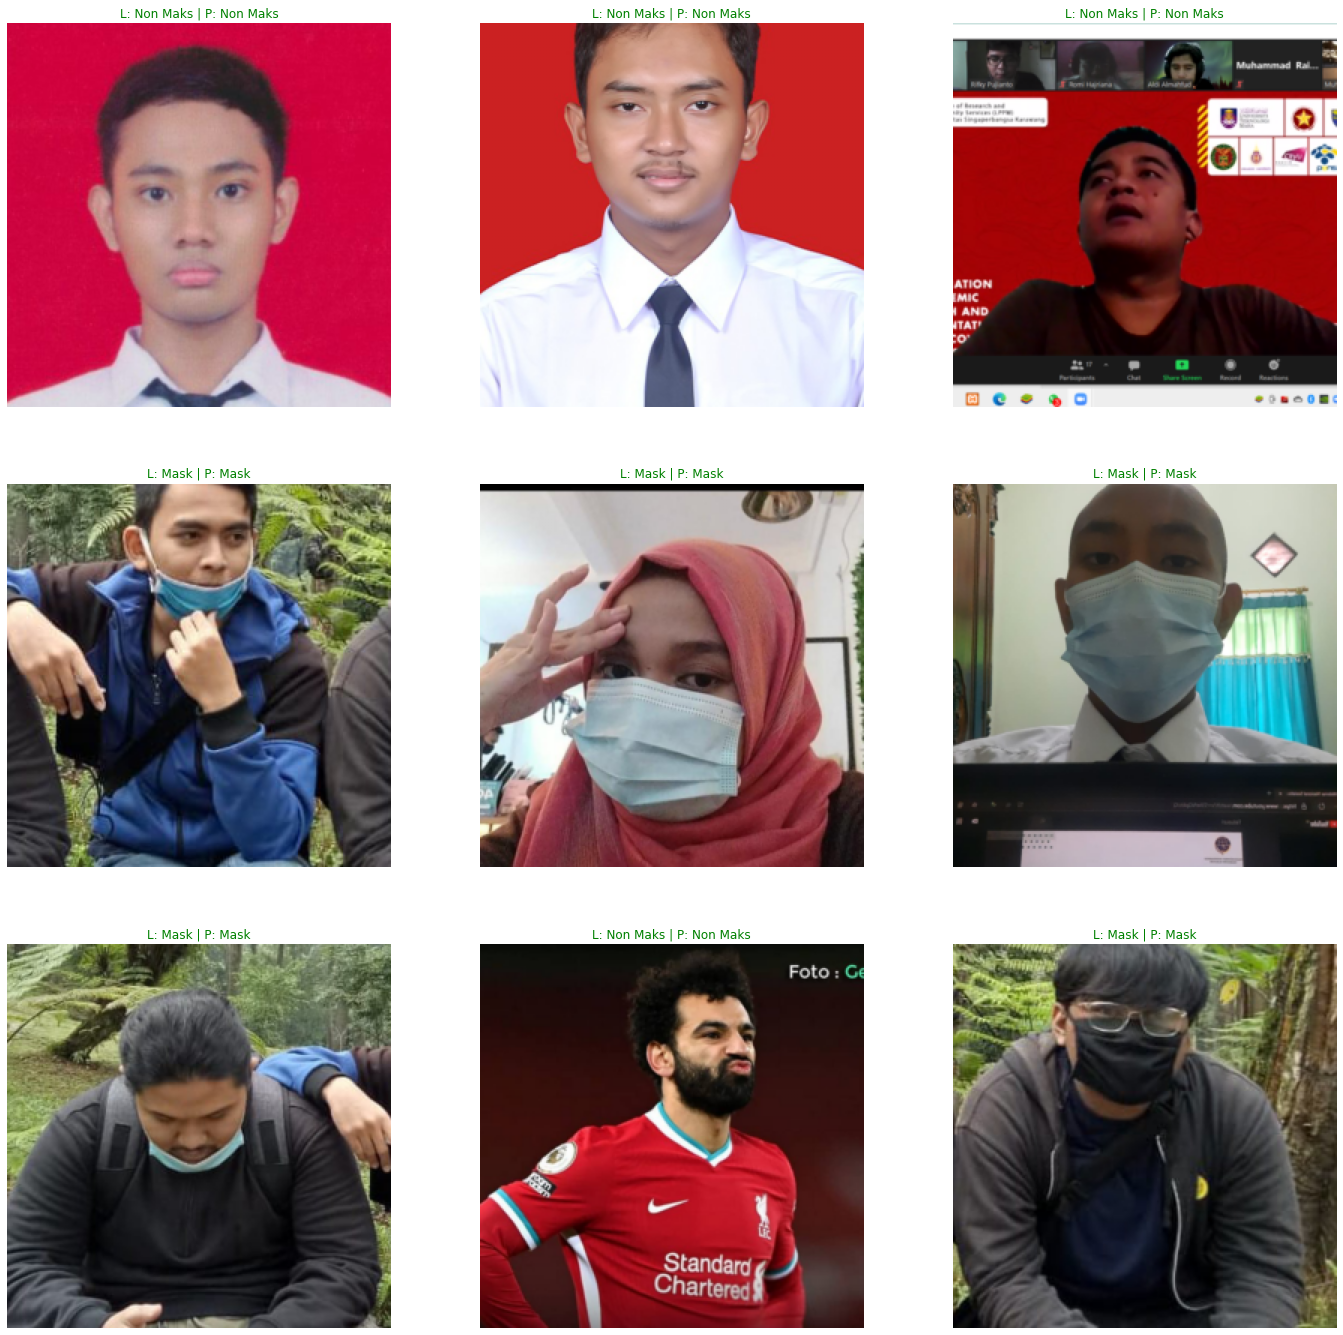

In [35]:
fig, axes = plt.subplots(3, 3, figsize=(24, 24))
for image, label, pred, ax in zip(feature.cpu(), target.cpu(), preds.cpu(), axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}        
    label, pred = test_set.classes[label.item()], test_set.classes[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');

### Singgle Predict

In [45]:
im = plt.imread("Foto Gue-min.jpg")

In [46]:
from torch.autograd import Variable
imsize = 256
loader = test_transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU


In [47]:
image = image_loader("Foto Gue-min.jpg")

In [48]:
with torch.no_grad():
    model.eval()
    output = model(image.to(device))
    preds = output.argmax(1)
preds

D:\Pemrograman\miniconda3\envs\my_env\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([1], device='cuda:0')

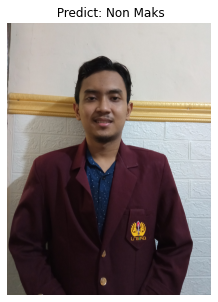

In [51]:
plt.figure(figsize=(5,5))
plt.imshow(im)
plt.axis(False)
plt.title(f" Predict: {pred}");
plt.show()